### DECISION TREE CLASSIFIER
In this assignment we will try to predict whether a vehicle is deemed accpetable or unacceptable depending upon factors such as maintenance, number of doors, safety, etc.

In [ ]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
# Define constants
COUNT_THRESHOLD = 10  # Count threshold for labeling a node as a leaf
MAX_DEPTH = 10  # Maximum depth for the decision tree

In [ ]:
from google.colab import drive
from sklearn.preprocessing import LabelEncoder

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/DataScience_Fundamentals_Assignment-3/car_evaluation.csv'
df = pd.read_csv(file_path)

print("First few rows of the dataset:")
print(df.head())
print("\nColumn names:", df.columns.tolist())


print("\nMissing values per column:")
print(df.isnull().sum())

df.dropna(inplace=True)

label_encoders = {}
for col in df.columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

data = df.values.tolist()
attributes = list(range(len(df.columns) - 1))

print("\nUnique values per column after encoding:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
First few rows of the dataset:
  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc

Column names: ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']

Missing values per column:
buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

Unique values per column after encoding:
buying: 4 unique values
maint: 4 unique values
doors: 4 unique values
persons: 3 unique values
lug_boot: 3 unique values
safety: 3 unique values
class: 4 unique values


In [ ]:
print(df.head())

   buying  maint  doors  persons  lug_boot  safety  class
0       3      3      0        0         2       1      2
1       3      3      0        0         2       2      2
2       3      3      0        0         2       0      2
3       3      3      0        0         1       1      2
4       3      3      0        0         1       2      2


In [ ]:
# Function 1: Calculate Gini Impurity
def calculate_gini(data):
    """
    Calculates the Gini impurity for a given dataset.

    Gini Impurity is a metric used to measure how "pure" a dataset is.
    - A pure dataset (all labels are the same) has Gini = 0.
    - A completely heterogeneous dataset has Gini close to 1.

    Formula:
        Gini = 1 - Σ(p_i^2)  for all labels i
        where p_i is the proportion of rows with label i.

    Args:
        data: A list of rows. Each row is a list, and the last element is the target label.

    Returns:
        A float representing the Gini impurity.
    """
    # Hint: Count the occurrences of each label in the dataset.
    # Hint: Compute the probability of each label and use the formula for Gini impurity.

    # TODO: Implement the Gini impurity formula

    label_counts = {}
    total_rows = len(data)

    for row in data:
        label = row[-1]
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1

    gini = 1.0
    for count in label_counts.values():
        prob = count / total_rows
        gini -= prob ** 2

    return gini

In [ ]:
# Test cases
print("Test 1 (pure label):", calculate_gini([[0], [0], [0]]))          # expect 0.0
print("Test 2 (even split):", calculate_gini([[0], [1]]))               # expect 0.5
print("Test 3 (50-50 mix):", calculate_gini([[0], [1], [1], [0]]))      # expect 0.5
print("Test 4 (3/4 of one label):", calculate_gini([[0], [0], [0], [1]])) # expect 0.375

for i, col in enumerate(df.columns):
    print(f"{col} → Unique values:", df[col].unique())


Test 1 (pure label): 0.0
Test 2 (even split): 0.5
Test 3 (50-50 mix): 0.5
Test 4 (3/4 of one label): 0.375
buying → Unique values: [3 0 2 1]
maint → Unique values: [3 0 2 1]
doors → Unique values: [0 1 2 3]
persons → Unique values: [0 1 2]
lug_boot → Unique values: [2 1 0]
safety → Unique values: [1 2 0]
class → Unique values: [2 0 3 1]


In [ ]:
# Function 2: Split dataset by an attribute
def split_data(data, attribute_index, value):
    """
    Splits the dataset into a subset based on the value of a specified attribute.

    Args:
        data: A list of rows. Each row is a list of attribute values.
        attribute_index: The index of the attribute to split on.
        value: The value of the attribute to match.

    Returns:
        A subset of the dataset where rows have the attribute at attribute_index equal to value.
    """
    # Hint: Use a list comprehension to filter rows based on the attribute value.
    # Hint: Remember to only include rows where data[attribute_index] == value.

    # TODO: Filter the rows based on the attribute value

    return [row for row in data if row[attribute_index] == value]


In [ ]:
# Function 3: Calculate Gini Gain
def gini_gain(data, attribute_index):
    """
    Calculates the Gini gain for a specific attribute.

    Gini Gain measures how much Gini impurity decreases when splitting the dataset
    on a specific attribute. The higher the gain, the better the attribute is for splitting.

    Formula:
        Gini Gain = Gini(parent) - Σ(weighted Gini(child subsets))

    Args:
        data: A list of rows. Each row is a list, and the last element is the target label.
        attribute_index: The index of the attribute to evaluate.

    Returns:
        A float representing the Gini gain for the attribute.
    """
    # Hint: Use calculate_gini() to compute the Gini impurity of the parent dataset.
    # Hint: Use split_data() to create subsets for each unique value of the attribute.
    # Hint: Compute the weighted Gini impurity for the subsets.

    # TODO: Implement the Gini gain formula


    parent_gini = calculate_gini(data)
    total_rows = len(data)

    unique_values = set(row[attribute_index] for row in data)

    weighted_gini = 0.0
    for value in unique_values:
        subset = split_data(data, attribute_index, value)
        if not subset:
          continue
        subset_gini = calculate_gini(subset)
        weight = len(subset) / total_rows
        weighted_gini += weight * subset_gini

    gain = parent_gini - weighted_gini
    return gain

    for value in unique_values:
      subset = split_data(data, attribute_index, value)
      print(f"  Value: {value} → Subset size: {len(subset)}")


In [ ]:
def majority_label(data):
    """Returns the most common label in the dataset."""
    labels = [row[-1] for row in data]
    return Counter(labels).most_common(1)[0][0]

def is_pure(data):
    """Checks if all rows have the same label."""
    labels = [row[-1] for row in data]
    return len(set(labels)) == 1

In [ ]:
# Function 4: Build the Decision Tree
def build_tree(data, attributes, depth=0):
    """
    Recursively builds a decision tree using Gini impurity to find the best splits.

    Stopping conditions:
    1. No attributes left to split on.
    2. Depth exceeds MAX_DEPTH.
    3. Number of elements in a leaf is less than COUNT_THRESHOLD.

    Args:
        data: A list of rows. Each row is a list, and the last element is the target label.
        attributes: A list of indices representing the available attributes for splitting.

    Returns:
        A dictionary representing the decision tree.
    """
    # Hint: Use calculate_gini() to check if the dataset is pure.
    # Hint: If no attributes remain, return the majority label in the dataset.
    # Hint: Use gini_gain() to find the best attribute for splitting.

    # This is what a decsision tree should look like
    # {2: {'Single': {3: {'Low': 'Yes', 'Medium': 'No', 'High': {1: {'Low': 'Yes', 'High': 'No'}}}}, 'Married': 'Yes', 'Divorced': 'No'}}

    # TODO: Handle stopping conditions



    if is_pure(data) or depth >= MAX_DEPTH or len(data) < COUNT_THRESHOLD or not attributes:
       return majority_label(data)


    best_gain = 0
    best_attribute = None
    for attr in attributes:
        gain = gini_gain(data, attr)
        if gain > best_gain:
            best_gain = gain
            best_attribute = attr

    if best_attribute is None:
        return majority_label(data)

    tree = {best_attribute: {}}
    unique_values = set(row[best_attribute] for row in data)

    for value in unique_values:
        subset = split_data(data, best_attribute, value)
        if not subset:
            tree[best_attribute][value] = majority_label(data)
        else:
            remaining_attrs = [a for a in attributes if a != best_attribute]
            subtree = build_tree(subset, remaining_attrs, depth + 1)
            tree[best_attribute][value] = subtree

    return tree

In [ ]:
# Function 5: Predict a Single Instance
def predict(tree, instance):
    """
    Predicts the label for a single instance using the decision tree.

    Args:
        tree: The decision tree (dictionary).
        instance: A dictionary where keys are attribute indices and values are the instance's attribute values.

    Returns:
        The predicted label for the instance.
    """
    # Hint: Traverse the tree based on the instance's attribute values.
    # Hint: If the current node is a dictionary, look up the next branch using the instance value.
    # Hint: If the current node is not a dictionary, return it as the predicted label.

    # TODO: Implement tree traversal logic for prediction

    if not isinstance(tree, dict):
        return tree

    attribute_index = next(iter(tree))
    branches = tree[attribute_index]
    instance_value = instance.get(attribute_index)

    # Traverse to the corresponding subtree if value is in branches
    if instance_value in branches:
        return predict(branches[instance_value], instance)
    else:
        # Value not seen during training: return majority vote or fallback
        return None  # or raise an exception / use a default strategy

In [ ]:


# Define a mapping for the categorical values to numerical values
value_mappings = {
    'buying': {'vhigh': 3, 'high': 2, 'med': 1, 'low': 0},
    'maint': {'vhigh': 3, 'high': 2, 'med': 1, 'low': 0},
    'doors': {'2': 0, '3': 1, '4': 2, '5more': 3},
    'persons': {'2': 0, '4': 1, 'more': 2},
    'lug_boot': {'small': 0, 'med': 1, 'big': 2},
    'safety': {'low': 0, 'med': 1, 'high': 2}
}

for column, mapping in value_mappings.items():
    df[column] = df[column].map(mapping)

# Map the target column
df['class'] = df['class'].map({'unacc': 0, 'acc': 1, 'good': 2, 'vgood': 3})


In [ ]:
# Build the decision tree
tree = build_tree(data, attributes)
print("Decision Tree:", tree)

Decision Tree: {5: {0: {3: {0: 2, 1: {0: {0: {1: {0: 0, 1: 0, 2: 0, 3: 2}}, 1: {1: {0: {4: {0: 3, 1: 0, 2: 0}}, 1: {4: {0: 3, 1: 1, 2: 1}}, 2: {4: {0: 3, 1: 1, 2: 1}}, 3: 0}}, 2: {1: {0: 0, 1: {4: {0: 3, 1: 1, 2: 1}}, 2: {4: {0: 3, 1: 0, 2: 0}}, 3: 0}}, 3: {1: {0: 2, 1: 0, 2: 0, 3: 2}}}}, 2: {0: {0: {1: {0: {2: {0: 0, 1: 0, 2: 0, 3: 0}}, 1: {2: {0: 0, 1: 0, 2: 0, 3: 0}}, 2: {2: {0: 0, 1: 0, 2: 0, 3: 0}}, 3: 2}}, 1: {1: {0: {4: {0: 3, 1: 3, 2: 0}}, 1: {4: {0: 3, 1: 3, 2: 1}}, 2: {4: {0: 3, 1: 3, 2: 1}}, 3: {2: {0: 0, 1: 0, 2: 0, 3: 0}}}}, 2: {1: {0: {2: {0: 0, 1: 0, 2: 0, 3: 0}}, 1: {4: {0: 3, 1: 3, 2: 1}}, 2: {4: {0: 3, 1: 3, 2: 0}}, 3: {2: {0: 0, 1: 0, 2: 0, 3: 0}}}}, 3: {1: {0: 2, 1: {2: {0: 0, 1: 0, 2: 0, 3: 0}}, 2: {2: {0: 0, 1: 0, 2: 0, 3: 0}}, 3: 2}}}}}}, 1: 2, 2: {3: {0: 2, 1: {0: {0: {4: {0: {1: {0: 0, 1: 0, 2: 0, 3: 2}}, 1: {2: {0: 2, 1: 2, 2: 0, 3: 0}}, 2: 2}}, 1: {1: {0: 0, 1: {4: {0: 1, 1: 0, 2: 0}}, 2: {4: {0: 1, 1: 0, 2: 0}}, 3: {4: {0: 0, 1: 2, 2: 2}}}}, 2: {1: {0: {4: {

<Figure size 1400x800 with 0 Axes>

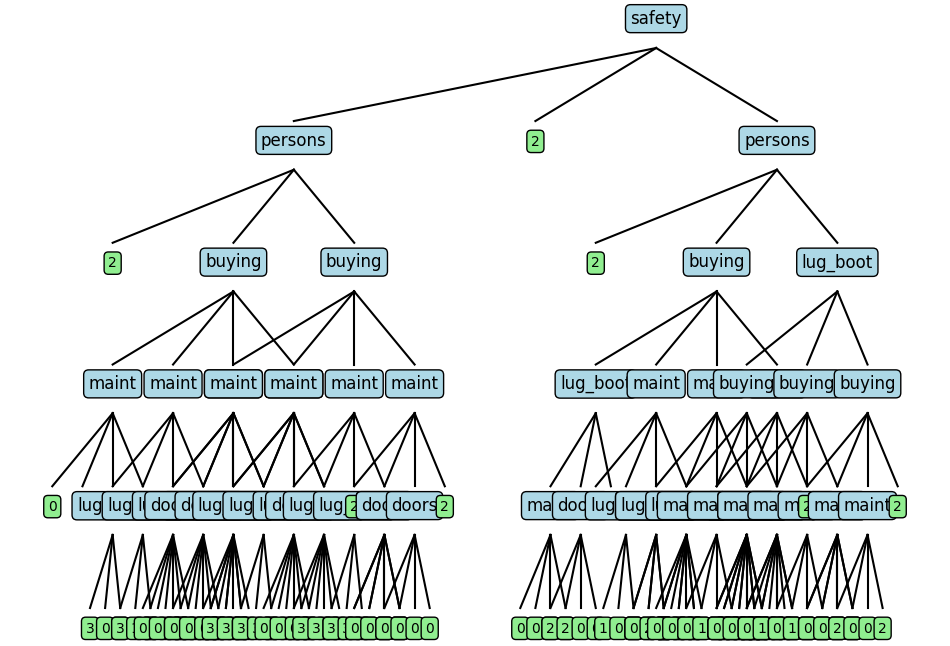

In [ ]:
def plot_tree(tree, x=0.5, y=1.0, dx=0.2, dy=0.1, ax=None, attribute_names=None, data=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis('off')

    if not isinstance(tree, dict):
        ax.text(x, y, str(tree), fontsize=10, ha='center',
                bbox=dict(boxstyle="round", facecolor="lightgreen"))
        return

    root = list(tree.keys())[0]
    attribute_name = attribute_names[root] if attribute_names else str(root)
    ax.text(x, y, attribute_name, fontsize=12, ha='center',
            bbox=dict(boxstyle="round", facecolor="lightblue"))

    children = list(tree[root].items())
    n = len(children)
    for i, (value, subtree) in enumerate(children):
        child_x = x + dx * (i - n / 2)
        child_y = y - dy
        ax.plot([x, child_x], [y - 0.02, child_y + 0.02], 'k-')

        # Recursively draw subtree
        plot_tree(subtree, x=child_x, y=child_y, dx=dx / 2, dy=dy,
                  ax=ax, attribute_names=attribute_names, data=data)

    if ax is None:
        plt.show()

plt.figure(figsize=(14, 8))
plot_tree(tree, data=data, attribute_names=attribute_names)


<Figure size 1400x800 with 0 Axes>

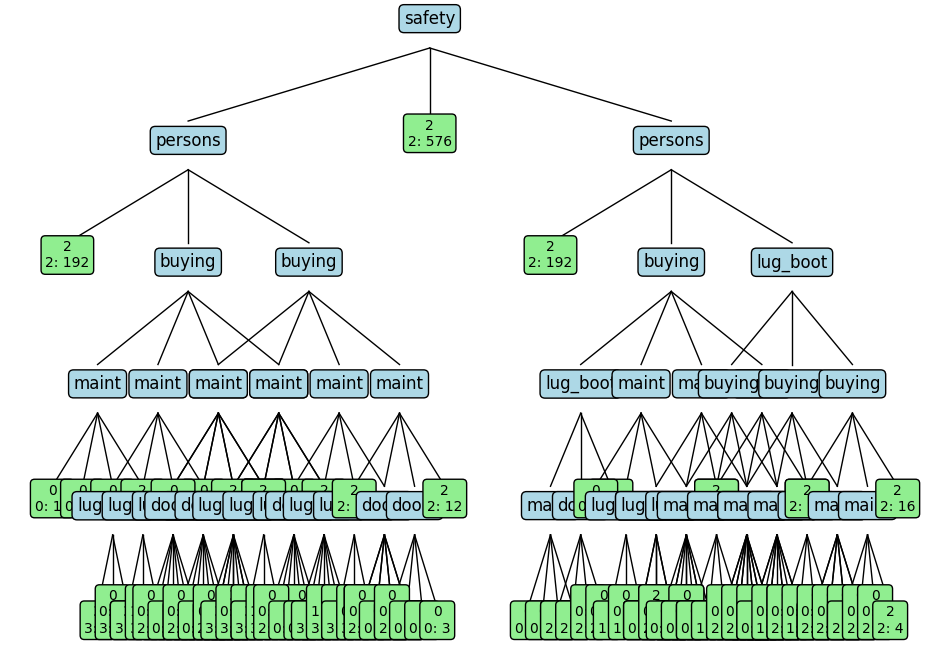

In [ ]:

# Visualize the decision tree
def plot_tree(tree, depth=0, x_offset=0.5, y_offset=1.0, x_gap=0.25, ax=None, data=None, attribute_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis('off')  # Turn off the axes

    # If the tree is a leaf node, plot the label and counts
    if not isinstance(tree, dict):
        # Count the occurrences of each label in the current leaf data subset
        label_counts = {label: sum(1 for row in data if row[-1] == label) for label in set(row[-1] for row in data)}
        # Format the label text to include counts of each class
        label_text = f"{tree}\n" + "\n".join([f"{label}: {count}" for label, count in label_counts.items()])
        ax.text(x_offset, y_offset, label_text, fontsize=10, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", edgecolor="black"))
        return

    # Get the current decision attribute name
    root = list(tree.keys())[0]
    attribute_name = attribute_names[root]  # Map the index to the attribute name
    ax.text(x_offset, y_offset, f"{attribute_name}", fontsize=12, ha='center',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", edgecolor="black"))

    # Recursively plot child nodes
    num_children = len(tree[root])
    for i, (value, subtree) in enumerate(tree[root].items()):
        child_x = x_offset + (i - (num_children - 1) / 2) * x_gap  # Calculate child x position
        child_y = y_offset - 0.1  # Shift vertically for the child nodes

        # Draw a line to the child node
        ax.plot([x_offset, child_x], [y_offset - 0.02, child_y + 0.02], 'k-', lw=1)

        # Recursively call plot_tree for the child node, passing the subset of data that corresponds to the child
        subset = split_data(data, root, value)  # Get the subset of data for this child
        plot_tree(subtree, depth + 1, child_x, child_y, x_gap / 2, ax=ax, data=subset, attribute_names=attribute_names)

    if depth == 0:  # Show the plot only at the top level
        plt.show()



# Visualize the decision tree
plt.figure(figsize=(14, 8))
plot_tree(tree, data=data, attribute_names=attribute_names)

In [ ]:
# Test prediction
test_instance = {0: 1, 1: 2}  # Middle-aged with High income
prediction = predict(tree, test_instance)
print("\nPrediction for test instance:", "Yes" if prediction == 1 else "No")


Prediction for test instance: No


In [ ]:
for attr in attributes:
    print(f"Attr {attr} → Gini Gain: {gini_gain(data, attr):.4f}")


Attr 0 → Gini Gain: 0.0143
Attr 1 → Gini Gain: 0.0118
Attr 2 → Gini Gain: 0.0016
Attr 3 → Gini Gain: 0.0713
Attr 4 → Gini Gain: 0.0052
Attr 5 → Gini Gain: 0.0768


In [ ]:
print("Full dataset Gini:", calculate_gini(data))

# Filter by label = 2 only (e.g. unacc only)
label2_data = [row for row in data if row[-1] == 2]
print("Gini of pure class (label 2):", calculate_gini(label2_data))

# Take a mixture: 3 from label=0, 3 from label=1
label0 = [row for row in data if row[-1] == 0][:3]
label1 = [row for row in data if row[-1] == 1][:3]
mixed_data = label0 + label1
print("Gini of 50-50 mix (label 0 & 1):", calculate_gini(mixed_data))
print(df.head())


Full dataset Gini: 0.457283763074417
Gini of pure class (label 2): 0.0
Gini of 50-50 mix (label 0 & 1): 0.5
   buying  maint  doors  persons  lug_boot  safety  class
0     NaN    NaN    NaN      NaN       NaN     NaN    NaN
1     NaN    NaN    NaN      NaN       NaN     NaN    NaN
2     NaN    NaN    NaN      NaN       NaN     NaN    NaN
3     NaN    NaN    NaN      NaN       NaN     NaN    NaN
4     NaN    NaN    NaN      NaN       NaN     NaN    NaN


In [ ]:
predicted_class = 2  # or whatever your tree returns
original_label = label_encoders['class'].inverse_transform([predicted_class])[0]
print(original_label)


unacc


In [ ]:
for i, col in enumerate(df.columns[:-1]):
    print(f"{col} → {df[col].nunique()} unique values")


buying → 0 unique values
maint → 0 unique values
doors → 0 unique values
persons → 0 unique values
lug_boot → 0 unique values
safety → 0 unique values
